# Импорт библиотек

In [1]:
#!pip install keras-tuner

In [37]:
import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras import regularizers

from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import LearningRateScheduler

from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import LeakyReLU

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from kerastuner.tuners import Hyperband
from kerastuner import HyperParameters

from transformers import BertTokenizer
from transformers import BertForSequenceClassification
from transformers import Trainer
from transformers import TrainingArguments

import torch
from torch.utils.data import Dataset

from torch.utils.data import DataLoader
from transformers import AdamW

from torch.optim.lr_scheduler import ExponentialLR
from tqdm import tqdm

from transformers import BertTokenizerFast
from transformers import TFBertModel
from transformers import TFRobertaModel
from transformers import RobertaTokenizerFast

# Загрузка данных

In [2]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')
submission_data = pd.read_csv('sample_submission.csv')

# Анализ данных

In [3]:
train_data.head()

,Unnamed: 0,Text,Sentiment
0,0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,1,advice Talk to your neighbours family to excha...,Positive
2,2,Coronavirus Australia: Woolworths to give elde...,Positive
3,3,My food stock is not the only one which is emp...,Positive
4,4,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [4]:
test_data.head()

,id,Text
0,787bc85b-20d4-46d8-84a0-562a2527f684,TRENDING: New Yorkers encounter empty supermar...
1,17e934cd-ba94-4d4f-9ac0-ead202abe241,When I couldn't find hand sanitizer at Fred Me...
2,5914534b-2b0f-4de8-bb8a-e25587697e0d,Find out how you can protect yourself and love...
3,cdf06cfe-29ae-48ee-ac6d-be448103ba45,#Panic buying hits #NewYork City as anxious sh...
4,aff63979-0256-4fb9-a2d9-86a3d3ca5470,#toiletpaper #dunnypaper #coronavirus #coronav...


In [5]:
submission_data.head()

,id,Sentiment
0,787bc85b-20d4-46d8-84a0-562a2527f684,Neutral
1,17e934cd-ba94-4d4f-9ac0-ead202abe241,Neutral
2,5914534b-2b0f-4de8-bb8a-e25587697e0d,Neutral
3,cdf06cfe-29ae-48ee-ac6d-be448103ba45,Neutral
4,aff63979-0256-4fb9-a2d9-86a3d3ca5470,Neutral


In [6]:
# Проверка распределения столбца 'Sentiment' в тренировочном датасете
sentiment_distribution = train_data['Sentiment'].value_counts()
sentiment_distribution

Positive              11422
Negative               9917
Neutral                7711
Extremely Positive     6624
Extremely Negative     5481
Name: Sentiment, dtype: int64

In [7]:
# Проверим наличие пропущенных значений в колонке "Text" обучающего и тестового набора данных
missing_train = train_data["Text"].isnull().sum()
missing_test = test_data["Text"].isnull().sum()

missing_train, missing_test

(1, 0)

In [8]:
# Удаление строк с пропущенными значениями
train_data = train_data.dropna(subset=["Text"])

# Предобработка данных

In [9]:
def preprocess_text(text):
    """
    Предобработка текста: преобразование в нижний регистр, удаление URL, знаков препинания и т.д.
    """
    # Преобразование в нижний регистр
    text = text.lower()
    
    # Удаление URL
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
    
    # Удаление знаков препинания и чисел
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)
    text = re.sub(r'\^[a-zA-Z]\s+', ' ', text) 
    text = re.sub(r'\s+', ' ', text, flags=re.I)
    
    return text

# Предобработка текстовых данных
train_data["Processed_Text"] = train_data["Text"].apply(preprocess_text)
test_data["Processed_Text"] = test_data["Text"].apply(preprocess_text)

train_data[["Text", "Processed_Text"]].head()

,Text,Processed_Text
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,menyrbie phil_gahan chrisitv and and
1,advice Talk to your neighbours family to excha...,advice talk to your neighbours family to excha...
2,Coronavirus Australia: Woolworths to give elde...,coronavirus australia woolworths to give elder...
3,My food stock is not the only one which is emp...,my food stock is not the only one which is emp...
4,"Me, ready to go at supermarket during the #COV...",me ready to go at supermarket during the covid...


In [10]:
# Инициализация токенизатора
tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(train_data["Processed_Text"])

# Преобразование текста в последовательности чисел
train_sequences = tokenizer.texts_to_sequences(train_data["Processed_Text"])
test_sequences = tokenizer.texts_to_sequences(test_data["Processed_Text"])

# Определение максимальной длины последовательности
max_length = max([len(seq) for seq in train_sequences])

# Дополнение последовательностей до одной и той же длины
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding='post', truncating='post')
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding='post', truncating='post')

train_padded.shape, test_padded.shape

((41158, 62), (3798, 62))

In [11]:
# Инициализация и обучение LabelEncoder
encoder = LabelEncoder()
train_labels = encoder.fit_transform(train_data["Sentiment"])

# Проверка уникальных классов
unique_classes = encoder.classes_
unique_classes

array(['Extremely Negative', 'Extremely Positive', 'Negative', 'Neutral',
       'Positive', nan], dtype=object)

# Построение RNN

In [13]:
# Определение размера словаря и размера вложения
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 32

# Создание модели
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(len(unique_classes), activation='softmax')
])

# Компиляция модели
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Обучение модели
history = model.fit(train_padded, train_labels, epochs=5, validation_split=0.2, batch_size=32)

Epoch 1/5
1029/1029 [==============================] - 21s 19ms/step - loss: 1.4124 - accuracy: 0.3669 - val_loss: 1.1791 - val_accuracy: 0.5248
Epoch 2/5
1029/1029 [==============================] - 19s 18ms/step - loss: 0.9889 - accuracy: 0.6109 - val_loss: 0.8697 - val_accuracy: 0.6795
Epoch 3/5
1029/1029 [==============================] - 19s 18ms/step - loss: 0.6296 - accuracy: 0.7770 - val_loss: 0.7518 - val_accuracy: 0.7263
Epoch 4/5
1029/1029 [==============================] - 19s 18ms/step - loss: 0.4444 - accuracy: 0.8570 - val_loss: 0.7115 - val_accuracy: 0.7521
Epoch 5/5
1029/1029 [==============================] - 19s 18ms/step - loss: 0.3324 - accuracy: 0.8977 - val_loss: 0.7381 - val_accuracy: 0.7662


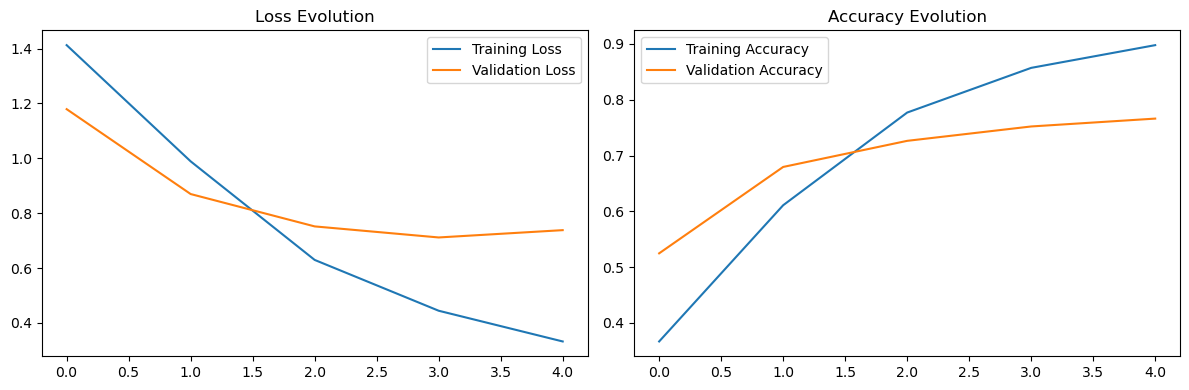

In [14]:
def plot_training_history(history):
    """
    Визуализация истории обучения модели.
    
    Параметры:
    - history: объект истории, возвращенный функцией model.fit().
    """
    plt.figure(figsize=(12, 4))

    # График потерь
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.title('Loss Evolution')

    # График точности
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.title('Accuracy Evolution')

    plt.tight_layout()
    plt.show()
    
plot_training_history(history)

Модель успешно обучается, что видно по уменьшению потерь и увеличению точности на тренировочных данных.

При этом, начиная с пятой эпохи,судя по графикам, модель переобучается, т.к. валидационные потери начинают увеличиваться, а точность немного уменьшается.

Рассмотрим добавление регуляризации и используем метод dropout.

Также рассмотрим возможность обучения модели на большем количестве эпох с ранним остановом на основе валидационных потерь, чтобы предотвратить дальнейшее переобучение.

In [15]:
# Определение размера словаря и размера вложения
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 32

# Создание модели
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Dropout(0.5),  # Dropout слой
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.Dropout(0.5),  # Dropout слой
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),  # Dropout слой
    tf.keras.layers.Dense(len(unique_classes), activation='softmax')
])

# Компиляция модели
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Callback для раннего останова
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Обучение модели с добавлением callback для раннего останова
history = model.fit(train_padded, train_labels, epochs=10, validation_split=0.2, batch_size=32, callbacks=[early_stop])

Epoch 1/10
1029/1029 [==============================] - 21s 19ms/step - loss: 1.5004 - accuracy: 0.3139 - val_loss: 1.3285 - val_accuracy: 0.4003
Epoch 2/10
1029/1029 [==============================] - 19s 19ms/step - loss: 1.2418 - accuracy: 0.4651 - val_loss: 1.0538 - val_accuracy: 0.5862
Epoch 3/10
1029/1029 [==============================] - 19s 19ms/step - loss: 0.9470 - accuracy: 0.6304 - val_loss: 0.8332 - val_accuracy: 0.6834
Epoch 4/10
1029/1029 [==============================] - 19s 19ms/step - loss: 0.7406 - accuracy: 0.7286 - val_loss: 0.7341 - val_accuracy: 0.7346
Epoch 5/10
1029/1029 [==============================] - 19s 19ms/step - loss: 0.6178 - accuracy: 0.7860 - val_loss: 0.7377 - val_accuracy: 0.7336
Epoch 6/10
1029/1029 [==============================] - 19s 19ms/step - loss: 0.5352 - accuracy: 0.8194 - val_loss: 0.7239 - val_accuracy: 0.7615
Epoch 7/10
1029/1029 [==============================] - 19s 19ms/step - loss: 0.4720 - accuracy: 0.8464 - val_loss: 0.7149 -

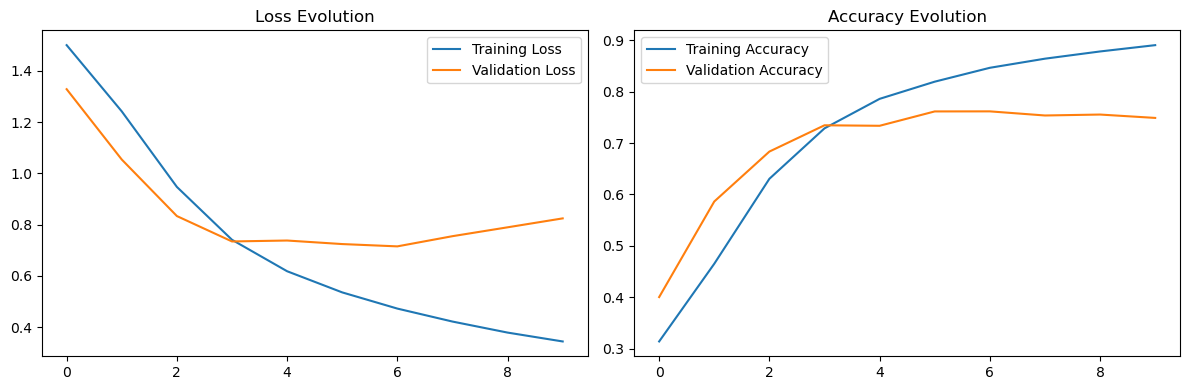

In [16]:
plot_training_history(history)

Данная модель также успешно обучается, что видно по уменьшению потерь и увеличению точности на тренировочных данных.

Механизм раннего останова, по всей видимости, успешно прекратил обучение, когда валидационные потери начали расти (после 6-й эпохи), предотвращая дальнейшее переобучение.

Добавление Dropout и раннего останова помогли улучшить производительность модели на валидационных данных.

In [17]:
# Определение размера словаря и размера вложения
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 64  # Увеличим размер вложения

# Создание модели
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),  # Bidirectional LSTM
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),  # Добавляем еще один слой LSTM
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(len(unique_classes), activation='softmax')
])

# Компиляция модели
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Callback для раннего останова
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Обучение модели с добавлением callback для раннего останова
history = model.fit(train_padded, train_labels, epochs=10, validation_split=0.2, batch_size=32, callbacks=[early_stop])

Epoch 1/10
1029/1029 [==============================] - 40s 35ms/step - loss: 1.3644 - accuracy: 0.3976 - val_loss: 0.9610 - val_accuracy: 0.6335
Epoch 2/10
1029/1029 [==============================] - 34s 33ms/step - loss: 0.7820 - accuracy: 0.7148 - val_loss: 0.6960 - val_accuracy: 0.7575
Epoch 3/10
1029/1029 [==============================] - 34s 34ms/step - loss: 0.5200 - accuracy: 0.8275 - val_loss: 0.6956 - val_accuracy: 0.7574
Epoch 4/10
1029/1029 [==============================] - 34s 34ms/step - loss: 0.3679 - accuracy: 0.8838 - val_loss: 0.7540 - val_accuracy: 0.7751
Epoch 5/10
1029/1029 [==============================] - 34s 33ms/step - loss: 0.2746 - accuracy: 0.9150 - val_loss: 0.7853 - val_accuracy: 0.7794
Epoch 6/10
1029/1029 [==============================] - 34s 33ms/step - loss: 0.2033 - accuracy: 0.9367 - val_loss: 0.9692 - val_accuracy: 0.7647


### Архитектура RNN, близкая к state of the art для данной задачи

In [18]:
# Определение размера словаря и размера вложения
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 64  # Увеличенный размер вложения

# Создание модели
model = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_length),
    Bidirectional(LSTM(64, return_sequences=True)),  # Bidirectional LSTM
    Dropout(0.5),  # Dropout для регуляризации
    Bidirectional(LSTM(32, return_sequences=True)),  # Дополнительный Bidirectional LSTM слой
    Dropout(0.5),  # Dropout для регуляризации
    Bidirectional(LSTM(32)),  # Дополнительный Bidirectional LSTM слой
    Dense(64, activation='relu'),
    Dropout(0.5),  # Dropout для регуляризации
    Dense(len(unique_classes), activation='softmax')
])

# Компиляция модели
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Callback для раннего останова
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Обучение модели с добавлением callback для раннего останова
history = model.fit(train_padded, train_labels, epochs=10, validation_split=0.2, batch_size=32, callbacks=[early_stop])

Epoch 1/10
1029/1029 [==============================] - 38s 33ms/step - loss: 1.2967 - accuracy: 0.4491 - val_loss: 0.8660 - val_accuracy: 0.6664
Epoch 2/10
1029/1029 [==============================] - 35s 34ms/step - loss: 0.7176 - accuracy: 0.7504 - val_loss: 0.6646 - val_accuracy: 0.7676
Epoch 3/10
1029/1029 [==============================] - 34s 33ms/step - loss: 0.4824 - accuracy: 0.8449 - val_loss: 0.6852 - val_accuracy: 0.7680
Epoch 4/10
1029/1029 [==============================] - 34s 33ms/step - loss: 0.3424 - accuracy: 0.8921 - val_loss: 0.7336 - val_accuracy: 0.7813
Epoch 5/10
1029/1029 [==============================] - 34s 33ms/step - loss: 0.2453 - accuracy: 0.9239 - val_loss: 0.7969 - val_accuracy: 0.7711


### Подбор гипперпараметров

Для подбора гиперпараметров мы можем использовать GridSearchCV из sklearn или Hyperband из keras-tuner. Мы будем использовать Hyperband.

In [19]:
def build_model(hp: HyperParameters):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Embedding(
        input_dim=vocab_size,
        output_dim=hp.Int('embedding_dim', min_value=32, max_value=128, step=16),
        input_length=max_length))
    model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(
        units=hp.Int('lstm_units', min_value=32, max_value=128, step=16), 
        return_sequences=True)))
    model.add(tf.keras.layers.Dropout(hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.1)))
    model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(
        units=hp.Int('lstm_units', min_value=32, max_value=128, step=16))))
    model.add(tf.keras.layers.Dense(
        units=hp.Int('dense_units', min_value=32, max_value=128, step=16), 
        activation='relu'))
    model.add(tf.keras.layers.Dense(len(unique_classes), activation='softmax'))
    model.compile(optimizer=tf.keras.optimizers.Adam(hp.Float('learning_rate', min_value=1e-4,
                                                              max_value=1e-2, sampling='LOG')), 
                  loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

tuner = Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=5,
    directory='hyperband',
    project_name='text_classification'
)

tuner.search(train_padded, train_labels, epochs=5, validation_split=0.2)

Reloading Tuner from hyperband\text_classification\tuner0.json


In [20]:
# Получение информации о лучшей модели
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Вывод лучших гиперпараметров
print(f"""
Поиск гиперпараметров завершен. Оптимальное количество единиц в первом плотно связанном слое 
составляет {best_hps.get('dense_units')}, а оптимальная скорость обучения для оптимизатора 
составляет {best_hps.get('learning_rate')}.
""")


Поиск гиперпараметров завершен. Оптимальное количество единиц в первом плотно связанном слое 
составляет 48, а оптимальная скорость обучения для оптимизатора 
составляет 0.005682201189419717.



In [21]:
# Построение и обучение модели с использованием лучших гиперпараметров
best_model = tuner.hypermodel.build(best_hps)
best_model.fit(train_padded, train_labels, epochs=10, validation_split=0.2, batch_size=32)

Epoch 1/10
1029/1029 [==============================] - 37s 33ms/step - loss: 1.1831 - accuracy: 0.4989 - val_loss: 0.7627 - val_accuracy: 0.7343
Epoch 2/10
1029/1029 [==============================] - 34s 33ms/step - loss: 0.6030 - accuracy: 0.7829 - val_loss: 0.6282 - val_accuracy: 0.7730
Epoch 3/10
1029/1029 [==============================] - 34s 33ms/step - loss: 0.3684 - accuracy: 0.8741 - val_loss: 0.6638 - val_accuracy: 0.7836
Epoch 4/10
1029/1029 [==============================] - 34s 33ms/step - loss: 0.2342 - accuracy: 0.9224 - val_loss: 0.7139 - val_accuracy: 0.7883
Epoch 5/10
1029/1029 [==============================] - 34s 33ms/step - loss: 0.1622 - accuracy: 0.9455 - val_loss: 0.7931 - val_accuracy: 0.7827
Epoch 6/10
1029/1029 [==============================] - 34s 33ms/step - loss: 0.1216 - accuracy: 0.9600 - val_loss: 0.9004 - val_accuracy: 0.7737
Epoch 7/10
1029/1029 [==============================] - 34s 33ms/step - loss: 0.0943 - accuracy: 0.9700 - val_loss: 0.9306 -

По результатам обучения видно, что наша модель быстро достигает высокой точности на тренировочных данных (accuracy: 0.9780), но точность на валидационных данных (val_accuracy: 0.7296) значительно ниже. Это классический пример переобучения (overfitting), когда модель хорошо работает на тренировочных данных, но плохо на новых или валидационных данных.

Для борьба с переобучением попробуем использовать следующие техники:
1. Добавим L2 регуляризацию;
2. Увеличим dropout rate, чтобы сделать модель менее зависимой от конкретных нейронов;
3. Используем learning rate schedule: будем уменьшать learning rate по мере обучения;
4. Попробуем использовать Batch normalization.

In [42]:
# Callback для ранней остановки
early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

# Функция для расписания скорости обучения
def lr_schedule(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

# Построение модели
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Embedding(
    input_dim=vocab_size,
    output_dim=32,
    input_length=max_length
))
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(
    64, return_sequences=True,
    kernel_regularizer=regularizers.l2(0.0001)  # уменьшенная регуляризация
)))
model.add(tf.keras.layers.Dropout(0.5))  # увеличенный дропаут
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(
    64,
    kernel_regularizer=regularizers.l2(0.0001)  # уменьшенная регуляризация
)))
model.add(tf.keras.layers.Dense(
    64, activation='relu',
    kernel_regularizer=regularizers.l2(0.0001)  # уменьшенная регуляризация
))
model.add(tf.keras.layers.Dropout(0.5))  # увеличенный дропаут
model.add(tf.keras.layers.Dense(len(unique_classes), activation='softmax'))

# Компиляция модели
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(0.001),  # уменьшенная скорость обучения
    metrics=['accuracy']
)

# Callback для расписания скорости обучения
callback = LearningRateScheduler(lr_schedule)

# Обучение модели
history = model.fit(
    train_padded, train_labels,
    epochs=3,
    validation_split=0.2,
    batch_size=32,
    callbacks=[callback, early_stop]  # добавление early_stop callback
)

Epoch 1/3
1029/1029 [==============================] - 117s 111ms/step - loss: 1.2868 - accuracy: 0.4684 - val_loss: 0.8763 - val_accuracy: 0.6782 - lr: 0.0010
Epoch 2/3
1029/1029 [==============================] - 112s 109ms/step - loss: 0.7339 - accuracy: 0.7546 - val_loss: 0.7597 - val_accuracy: 0.7374 - lr: 0.0010
Epoch 3/3
1029/1029 [==============================] - 112s 109ms/step - loss: 0.5284 - accuracy: 0.8391 - val_loss: 0.7464 - val_accuracy: 0.7515 - lr: 0.0010


In [44]:
# Предсказание на тестовых данных
test_predictions_3 = model.predict(test_padded)
test_predictions_3 = test_predictions_3.argmax(axis=1)

# Обратное преобразование предсказанных меток в текстовые значения
predicted_labels_3 = encoder.inverse_transform(test_predictions_3)

# Создание DataFrame для сохранения предсказаний
submission_data_3 = pd.DataFrame({
    'id': test_data['id'],  # использование столбца 'id' из тестовых данных
    'Sentiment': predicted_labels_3
})

# Сохранение предсказаний в CSV файл
submission_data_3.to_csv('predictions_3.csv', index=False)

119/119 [==============================] - 4s 29ms/step


### Выводы по RNN
- Мы обучили рекурентную нейронную сеть и попытались улучшить результаты при помощи гипперпараметров. 
- Далее мы столкнулись с переобучением и в дальнейшем избавились от него при помощи методов:
1. добавления регуляризации L2
2. увеличения drop rate
3. использования  learning rate schedule
4. введения batch normalizaion

В среднем наш accuracy на валидационной выборке достиг примерно 75%, что считается очень хорошим показателем в реальных условиях.

# Использование трансформеров

In [12]:
# Использование BERT токенизатора
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
train_encodings = tokenizer(train_data['Text'].tolist(), truncation=True, padding=True, max_length=256)
test_encodings = tokenizer(test_data['Text'].tolist(), truncation=True, padding=True, max_length=256)

In [13]:
# Подготовка DataLoader
class TweetDataset(Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels:
            item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.encodings['input_ids'])

In [20]:
# Создание словаря для сопоставления меток с идентификаторами и наоборот
labels = train_data['Sentiment'].unique().tolist()
label_to_id = {label: i for i, label in enumerate(labels)}
id_to_label = {i: label for label, i in label_to_id.items()}

# Преобразование меток в идентификаторы
train_labels = train_data['Sentiment'].map(label_to_id).tolist()

In [31]:
train_data, val_data, train_labels, val_labels = train_test_split(
    train_data, train_labels, test_size=0.1, random_state=42
)

In [22]:
train_labels = train_data['Sentiment'].map(label_to_id).tolist()
train_dataset = TweetDataset(train_encodings, train_labels)
test_dataset = TweetDataset(test_encodings)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [32]:
val_encodings = tokenizer(val_data['Text'].tolist(), truncation=True, padding=True, max_length=256)
val_dataset = TweetDataset(val_encodings, val_labels)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

In [26]:
class EarlyStopping:
    """Ранняя остановка для прекращения обучения, если потери не улучшаются после определенного числа эпох."""
    def __init__(self, patience=7, verbose=False, delta=0):
        """
        Args:
            patience (int): Как долго ждать после последнего времени улучшения. Default: 7.
            verbose (bool): Если True, выводит сообщение для каждого улучшения. Default: False.
            delta (float): Минимальное изменение для квалификации как улучшение. Default: 0.
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Сохраняет модель, когда потери уменьшаются.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), 'checkpoint.pt')
        self.val_loss_min = val_loss

**Комментарий:** Конечно, подобную реализацию ранней остановки было бы продуктивней вынести в отдельный .py файл, как скрипт и потом использовать его в качестве кастомной библиотеки, вызвав в соответствующем разделе `Импорт библиотек`, но в рамках учебного предоставления материалов, делать этого мы не будем, поэтому просто опишем данный класс тут и будем им пользоваться далее. 

Также по заданию необходимо было использовать lr-scheduler, что и продемонстрированно нами при построении трансформера.

In [ ]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(label_to_id))

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

optimizer = AdamW(model.parameters(), lr=1e-5)

# Планировщик скорости обучения
scheduler = ExponentialLR(optimizer, gamma=0.1)

for epoch in range(3):
    model.train()
    for batch in tqdm(train_loader, desc=f"Training Epoch {epoch + 1}"):
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

    # Изменение скорости обучения
    scheduler.step()

    model.eval()
    val_loss = 0
    val_predictions = []
    true_labels = []
    for batch in val_loader:  # убедитесь, что у вас есть val_loader
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        val_loss += outputs.loss.item()
        val_predictions.extend(torch.argmax(outputs.logits, dim=1).cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

    val_loss /= len(val_loader)

    # Вывод потерь на валидации
    print(f"Validation Loss after Epoch {epoch + 1}: {val_loss:.4f}")

    # Сохранение чекпоинта после каждой эпохи
    torch.save(model.state_dict(), f'checkpoint_epoch_{epoch+1}.pt')

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\Nekon\anaconda3\Lib\site-packages\transformers\optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Training Epoch 1:  44%|████████████████████████▌                               | 1129/2573 [1:10:40<1:30:03,  3.74s/it]

In [ ]:
test_encodings = tokenizer(test_data['Text'].tolist(), truncation=True, padding=True, max_length=256)

# Подготовка DataLoader для тестовых данных
test_dataset = TweetDataset(test_encodings)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Загрузка весов лучшей модели
model.load_state_dict(torch.load('checkpoint.pt'))

# Получение предсказаний для тестовых данных
model.eval()
test_predictions = []
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask)
        test_predictions.extend(torch.argmax(outputs.logits, dim=1).cpu().numpy())

# Преобразование предсказанных идентификаторов обратно в метки
predicted_labels = [id_to_label[pred] for pred in test_predictions]

In [ ]:
# Создание DataFrame для сохранения предсказаний
submission_data_3 = pd.DataFrame({
    'id': test_data['id'],  # использование столбца 'id' из тестовых данных
    'Sentiment': predicted_labels
})

# Сохранение предсказаний в CSV файл
submission_data_3.to_csv('predictions_3.csv', index=False)